In [1]:
import tensorflow as tf

### Configuration
create_dataset = False

def in_google_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Get the platform
if in_google_colab():
    print("Running in Google Colab")
    !git clone https://github.com/naderinho/anesthesia_anomaly_detection
    !pip install vitaldb
    directory = 'anesthesia_anomaly_detection/data/'
    create_dataset = False
else:
    print("Running locally")
    directory = 'data/'

### Datasetpath
datasetpath = 'dataset01/'
vitaldbpath = 'vitaldb_tiva/'

import numpy as np
import pandas as pd
import vitaldb as vf
import matplotlib.pyplot as plt

Running in Google Colab
Cloning into 'anesthesia_anomaly_detection'...
remote: Enumerating objects: 173, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 173 (delta 60), reused 135 (delta 31), pack-reused 0
Receiving objects: 100% (173/173), 29.05 MiB | 7.51 MiB/s, done.
Resolving deltas: 100% (60/60), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 717.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 8.1 MB/s eta 0:00:00


In [2]:
from scipy import ndimage

def outlierfilter(data: pd.DataFrame,threshhold: float, iterations: int, min: float, max: float):
    """
    A filter function, which calculates the gradient of a given Pandas DataFram Timeseries
    and performs a binary dilation on datapoints which exceed a certain treshhold, to detect
    and remove unwanted outliers in the dataset. Additionally all values exceeding a given
    min/max value are replaced with np.nan and linearly interpolated with the Pandas interpolate
    method.

    Args:
        data (pd.DataFrame): Timeseries Data
        threshhold (float): Gradient thresshold
        iterations (int): number of iterations of the binary dilation
        min (float): maximum expected value
        max (float): minimum expected value

    Returns:
        pd.DataFrame: _description_
    """
    gradient = np.diff(data,n=1, axis=0, append=0)
    gradientfilter = ndimage.binary_dilation(np.abs(gradient) > threshhold, iterations=iterations)

    # Apply Filter
    data[gradientfilter] = np.nan

    data[data <= min] = np.nan
    data[data > max] = np.nan

    data = data.interpolate(method = 'linear')
    data = data.bfill()
    return data

### Custom Normalization Functions

def NormStandard(dataset: np.array):
    mean = np.nanmean(dataset)
    std = np.nanstd(dataset)
    return (dataset - mean) / std

def NormMinMax(dataset: np.array):
    min = np.min(dataset)
    max = np.max(dataset)
    return (dataset - min) / (max - min)

def NormCustomBIS(dataset: np.array):
    return (100 - dataset) / 100

def NormNone(dataset: np.array):
    return dataset

In [3]:
from os import listdir
from sklearn.model_selection import train_test_split

class DatasetImport():
    def __init__(self, directory: str, dataset: str, vitalpath: str, interval: int = 10):
        self.directory = directory
        self.datasetpath = directory + dataset
        self.vitalpath = directory + vitalpath

        self.interval = interval

        self.train_dataset = None
        self.validation_dataset = None
        self.test_dataset = None

        self.index = pd.read_csv(self.datasetpath +'dataset.csv', index_col=0).index.to_numpy()

    def save(self, filename: str):
        np.savez_compressed(self.datasetpath+filename,
                            train = self.train_dataset,
                            validation = self.validation_dataset,
                            test = self.test_dataset,
                            timesteps = self.timesteps,
                            )

    def load(self, filename: str):
        data = np.load(self.datasetpath+filename)
        self.train_dataset = data['train']
        self.validation_dataset = data['validation']
        self.test_dataset = data['test']
        try:
            self.timesteps = data['timesteps']
        except:
            self.timesteps = []

    def split(self,data):
       train, test = train_test_split(data, test_size=0.15, random_state=42)
       train, validation = train_test_split(train, test_size=0.15, random_state=42)
       return train, validation, test

    def generateDataset(self, normalization):

        dataset, self.timesteps = self.generate(self.index, normalization)

        self.train_dataset, self.validation_dataset, self.test_dataset = self.split(dataset)
        print('Dataset succesfully generated                 ')

    def generate(self, dataset_index: list, normalization):
        batch_list = []
        timesteps = []

        for i, caseid in enumerate(dataset_index):
            filepath = self.vitalpath+str(caseid).zfill(4)+'.vital'
            data, importName = self.importFunction(filepath)
            timesteps.append(data.shape[0])
            batch_list.append(data)
            print(importName + " Fortschritt: %.1f" % (100 * (i+1) / len(dataset_index)),' % ', end='\r')

        ### Pad the dataset
        data = tf.keras.preprocessing.sequence.pad_sequences(batch_list, padding='post', dtype='float32', value=0.0)

        # Remove 0.0 padded values
        data[data == 0.0] = np.nan

        # Nomalization
        data = normalization(data)

        # restore padded values
        np.nan_to_num(data, copy=False, nan=0.0)

        return data, np.array(timesteps)

    def importFunction(self, filepath: str):
        return None, None

class infoImport(DatasetImport):
    def __init__(self, directory: str, dataset: str, vitalpath: str):
        super().__init__(directory,dataset,vitalpath)

        self.columns = ['sex','age','height','weight','bmi']

    def generate(self, dataset_index: list, normalization):

        data = pd.read_csv(self.directory+'info_vitaldb/cases.csv', index_col=0)
        data = data[self.columns].loc[dataset_index].to_numpy()

        sex = np.where(data[:, 0] == 'F', -0.5, 0.5)

        data = data[:,1:].astype(float)
        data = np.c_[sex, normalization(data)]

        return data, None

class VitalImport(DatasetImport):
    def __init__(self, directory: str, dataset: str, vitalpath: str):
        super().__init__(directory,dataset,vitalpath)

        self.tracks = []
        self.filter = [0,0,0]
        self.name = 'Vital'

    def importFunction(self, filepath: str):

        vitaldata = vf.VitalFile(ipath = filepath, track_names = self.tracks)

        data = vitaldata.to_pandas(track_names=self.tracks,interval=self.interval)
        data = data + 0.00001 # adds small value to avoid mix up with padding values
        data = outlierfilter(data, threshhold = self.filter[0] , iterations = 2, min = self.filter[1], max = self.filter[2])

        return data, self.name

class BPImport(DatasetImport):
    def __init__(self, directory: str, dataset: str, vitalpath: str):
        super().__init__(directory,dataset,vitalpath)

    def importFunction(self, filepath: str):
        pressureWave = vf.VitalFile(filepath).to_numpy(['SNUADC/ART'], 1/500)

        samples = self.interval * 500

        # Remove values which derivative is too large
        gradient = np.diff(pressureWave,n=1, axis=0, append=0)
        gradientfilter1 = ndimage.binary_dilation(np.abs(gradient) > 4,iterations=30)
        gradientfilter2 = ndimage.binary_dilation(np.abs(gradient) > 7,iterations=1000)
        pressureWave[gradientfilter1] = np.nan
        pressureWave[gradientfilter2] = np.nan

        # Remove the negative values and values above 250
        pressureWave[pressureWave <= 20] = np.nan
        pressureWave[pressureWave > 250] = np.nan

        pressureWave = self.imputer1.fit_transform(pressureWave)

        ### Reshape the pressureWave to 1000 samples (2 seconds) per row
        #if (pressureWave.shape[0] % samples) != 0 :
        #    steps2fill = samples - (pressureWave.shape[0] % samples)
        #    pressureWave = np.pad(array=pressureWave, pad_width=((0,steps2fill),(0,0)), mode='constant', constant_values=np.nan)
        length = pressureWave.shape[0] - (pressureWave.shape[0] % samples)
        pressureWave = pressureWave[0:length]
        return pressureWave.reshape(-1,samples), 'Blood Pressure'

In [4]:
###### Create Dataset
if create_dataset:
    bis = VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    bis.name = 'Bispektralindex'
    bis.tracks = ['BIS/BIS']
    bis.filter = [20, 10, 100]
    bis.generateDataset(normalization=NormCustomBIS)
    bis.save('00_bis.npz')

    info = infoImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    info.generateDataset(normalization=NormStandard)
    info.save('01_info.npz')

    bloodpressure = VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    bloodpressure.name = 'bloodpressure'
    bloodpressure.tracks = ['Solar8000/ART_DBP', 'Solar8000/ART_MBP', 'Solar8000/ART_SBP']
    bloodpressure.filter = [20, 20, 250]
    bloodpressure.generateDataset(normalization=NormStandard)
    bloodpressure.save('02_bloodpressure.npz')

    etCO2 = VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    etCO2.name = 'End Tidal CO2'
    etCO2.tracks = ['Primus/ETCO2']
    etCO2.filter = [5, 15, 50]
    etCO2.generateDataset(normalization=NormStandard)
    etCO2.save('02_etCO2.npz')

    spO2 = VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    spO2.name = 'SpO2'
    spO2.tracks = ['Solar8000/PLETH_SPO2']
    spO2.filter = [3, 80, 100]
    spO2.generateDataset(normalization=NormStandard)
    spO2.save('02_spO2.npz')

    hr = VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    hr.name = 'Heart Rate'
    hr.tracks = ['Solar8000/HR']
    hr.filter = [20, 40, 180]
    hr.generateDataset(normalization=NormStandard)
    hr.save('02_hr.npz')



In [5]:
### Load the datasets
bis = VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
bis.load('00_bis.npz')

info = infoImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
info.load('01_info.npz')

bloodpressure = VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
bloodpressure.load('02_bloodpressure.npz')

etCO2 = VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
etCO2.load('02_etCO2.npz')

spO2 = VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
spO2.load('02_spO2.npz')

hr = VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
hr.load('02_hr.npz')

In [30]:
########################################## COMBINED MODEL ##########################################
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, ReLU, Dropout, Concatenate, Masking, Conv1D, MaxPooling1D, BatchNormalization, RepeatVector
from tensorflow.keras.metrics import RootMeanSquaredError, MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError

### LSTM layers for the blood pressure data

### Combine the vital data
vital_train = np.concatenate([bloodpressure.train_dataset, etCO2.train_dataset, spO2.train_dataset, hr.train_dataset], axis=2)
vital_validation = np.concatenate([bloodpressure.validation_dataset, etCO2.validation_dataset, spO2.validation_dataset, hr.validation_dataset], axis=2)
vital_test = np.concatenate([bloodpressure.test_dataset, etCO2.test_dataset, spO2.test_dataset, hr.test_dataset], axis=2)

### LSTM layers for the vital data
input_vital = Input(shape=(None, vital_train.shape[2]))
vital_layer = Masking(mask_value=0.0)(input_vital)

### INFO layers
input_info = Input(shape=(info.train_dataset.shape[1],))
info_layer = RepeatVector(vital_train.shape[1])(input_info)

## Concatenate the LSTM output with the info layer
comb_layer = Concatenate()([vital_layer, info_layer])
comb_layer = LSTM(units=32, return_sequences=True)(comb_layer)
comb_layer = BatchNormalization()(comb_layer)
comb_layer = LSTM(units=32, return_sequences=True)(comb_layer)
comb_layer = BatchNormalization()(comb_layer)
comb_layer = LSTM(units=32, return_sequences=True)(comb_layer)
comb_layer = BatchNormalization()(comb_layer)
comb_layer = Dense(units=128, activation='relu')(comb_layer)
comb_layer = BatchNormalization()(comb_layer)
comb_layer = Dense(units=32, activation='relu')(comb_layer)
comb_layer = BatchNormalization()(comb_layer)


output = Dense(units=1)(comb_layer)
output = ReLU(max_value=1.0)(output)

# Define the model
model = Model(inputs=[input_vital, input_info], outputs=output)

# Compile the model
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              #loss=tf.keras.losses.Huber(),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['MeanSquaredError','MeanAbsoluteError','RootMeanSquaredError']
              )

#model.summary()
y = pd.DataFrame(bis.train_dataset[:,:,0].T).rolling(min_periods=1,window=5, center=True).mean().to_numpy().T[:,:,np.newaxis]

# Train the model
history = model.fit([vital_train, info.train_dataset],
                    bis.train_dataset,
                    validation_data=([vital_validation, info.validation_dataset], bis.validation_dataset),
                    epochs=30,
                    batch_size=4
                    )

Epoch 1/30
28/28 [==============================] - 24s 322ms/step - loss: 0.2128 - mean_squared_error: 0.2135 - mean_absolute_error: 0.4193 - root_mean_squared_error: 0.4621 - val_loss: 0.2411 - val_mean_squared_error: 0.2407 - val_mean_absolute_error: 0.4725 - val_root_mean_squared_error: 0.4906
Epoch 2/30
28/28 [==============================] - 5s 187ms/step - loss: 0.1538 - mean_squared_error: 0.1544 - mean_absolute_error: 0.3366 - root_mean_squared_error: 0.3929 - val_loss: 0.1578 - val_mean_squared_error: 0.1573 - val_mean_absolute_error: 0.3765 - val_root_mean_squared_error: 0.3966
Epoch 3/30
28/28 [==============================] - 6s 229ms/step - loss: 0.0943 - mean_squared_error: 0.0943 - mean_absolute_error: 0.2435 - root_mean_squared_error: 0.3071 - val_loss: 0.0892 - val_mean_squared_error: 0.0885 - val_mean_absolute_error: 0.2749 - val_root_mean_squared_error: 0.2975
Epoch 4/30
28/28 [==============================] - 6s 208ms/step - loss: 0.0644 - mean_squared_error: 0.

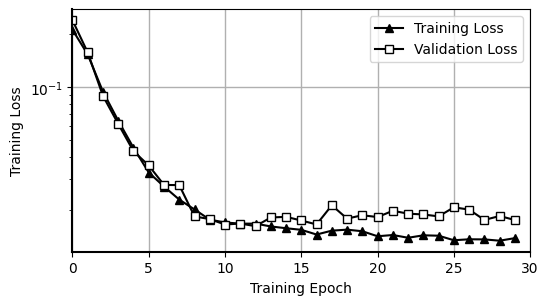

In [35]:
########################################## TRAINING SUMMARY ##########################################

# Evaluate the mod
train_score = history.history
# Plot configuration
plt.figure(figsize=(15/2.54, 8/2.54))

# Actual plot
plt.plot(train_score['loss'], label='Training Loss', color='k', marker='^', markerfacecolor='k')
plt.plot(train_score['val_loss'], label='Validation Loss', color='k', marker='s', markerfacecolor='w')

# Title and labels
#plt.title('Training Model loss')
plt.xlabel('Training Epoch')
plt.ylabel('Training Loss')
plt.yscale("log")
plt.xlim(0, 30)
plt.legend()

# Axis settings
ax = plt.gca()
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)



plt.grid(True, linewidth=1.0)
plt.savefig('training_loss_bs4_relu.pdf', bbox_inches='tight', pad_inches=0.2, format='pdf')

plt.show()

In [32]:
########################################## TESTING ##########################################
import matplotlib.pyplot as plt
from prettytable import PrettyTable

# Prediction
y_test = []
y_pred_test = []

y_pred =  model.predict([vital_test, info.test_dataset])
y_pred = - (y_pred * 100) + 100

ground_truth = - (bis.test_dataset * 100) + 100
ground_truth[ground_truth == 0] = np.nan

baseline = NormCustomBIS((bis.test_dataset != 0.0) * 41.0)
baseline[baseline == 1.0] = np.nan
baseline_score = [0, np.nanmean(np.square(bis.test_dataset - baseline)),      # MSE
                  np.nanmean(np.abs(bis.test_dataset - baseline)),            # MAE
                  np.sqrt(np.nanmean(np.square(baseline - bis.test_dataset))) # RMSE
                  ]

train_index, val_index, test_index = bis.split(np.array(bis.index))
timesteps = bis.split(bis.timesteps)[2]

### Evaluate Test Score
test_score = model.evaluate([vital_test, info.test_dataset], bis.test_dataset, verbose=False)

t = PrettyTable(['Metric', 'Train Score', 'Test Score', 'Baseline'], digits = 2)
for i, metric in enumerate(model.metrics_names):
  if metric == 'loss': continue
  t.add_row([metric, train_score[metric][-1], test_score[i], baseline_score[i]])
print(t)

1/1 [==============================] - 6s 6s/step
+-------------------------+----------------------+----------------------+----------------------+
|          Metric         |     Train Score      |      Test Score      |       Baseline       |
+-------------------------+----------------------+----------------------+----------------------+
|    mean_squared_error   | 0.013665379025042057 | 0.011961977928876877 | 0.013987312182389586 |
|   mean_absolute_error   | 0.08874383568763733  | 0.07887769490480423  | 0.07548295934411452  |
| root_mean_squared_error | 0.11689901351928711  | 0.10937082767486572  | 0.11826796769366414  |
+-------------------------+----------------------+----------------------+----------------------+


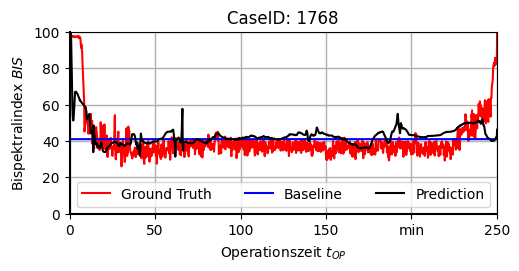

In [36]:
j = 8
time = np.arange(0, y_pred[j].shape[0]) * 10 / 60

plt.figure(figsize=(14/2.54, 6/2.54))
plt.rcParams['font.size'] = 10

# Colors
color1 = (0, 0, 0)
color2 = (1, 1, 1)
color3 = (159/255, 182/255, 196/255)
color4 = (125/255, 102/255, 102/255)
color5 = (153/255, 0, 0)

plt.plot(time,ground_truth[j], label='Ground Truth', color='r')
plt.plot(time,-(baseline[j,:,:] * 100) + 100, label='Baseline', color='b')
plt.plot(time,y_pred[j], label='Prediction', color='k')

plt.title('CaseID: '+str(test_index[j]))
plt.xlabel('Operationszeit $t_{OP}$')
plt.ylabel('Bispektralindex $BIS$')

plt.legend(loc='lower center', mode="expand", ncol=3)

# Axis settings
ax = plt.gca()
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

# Limits
ax.set_ylim(bottom=0, top=100)
ax.set_xlim(left=0, right= 250)

# Einheiten auf x-Achse
xunit = 'min'
ticks = ax.get_xticks()
ticks = [int(tick) for tick in ticks]
ticks_with_units = [xunit if i == len(ticks) - 2 else ticks[i] for i in range(len(ticks))]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks_with_units)

plt.grid(True, linewidth=1.0)

plt.savefig('sample_bs4_relu.pdf', bbox_inches='tight', pad_inches=0.2, format='pdf')

plt.show()

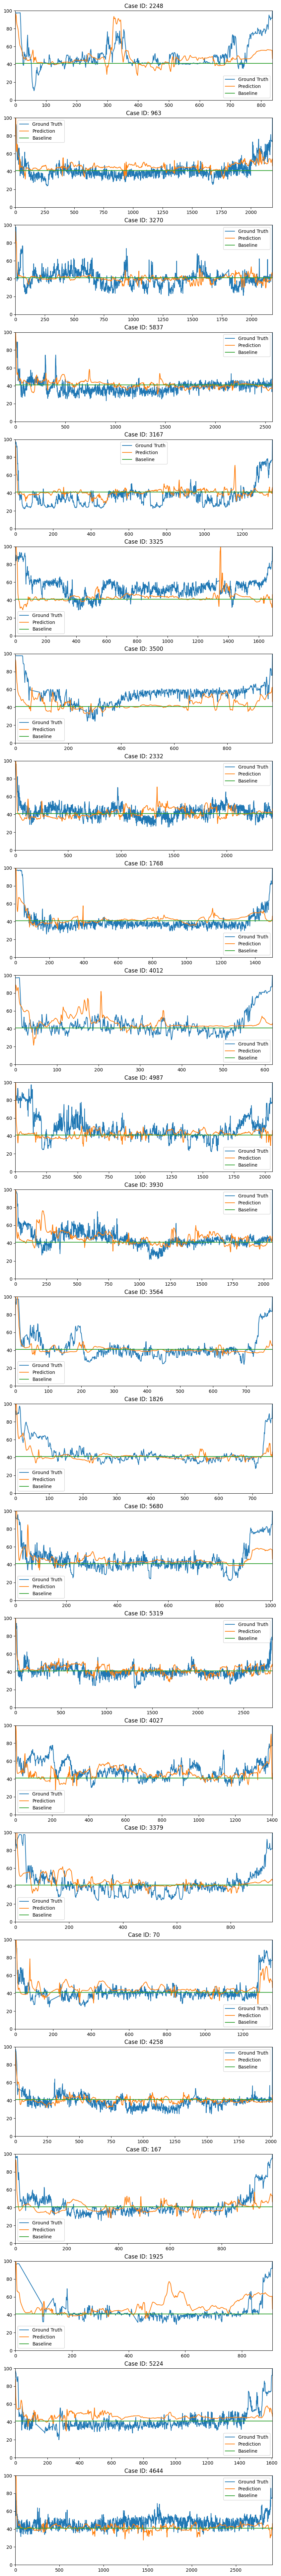

In [34]:
### Plot Test Results
fig, axs = plt.subplots(bis.test_dataset.shape[0], 1, figsize=(10, 100))

for j, filename in enumerate(test_index):
    axs[j].plot(ground_truth[j,:,:], label='Ground Truth')
    axs[j].plot(y_pred[j,:,:], label='Prediction')
    axs[j].plot(-(baseline[j,:,:] * 100) + 100, label='Baseline')
    axs[j].legend()
    axs[j].set_title('Case ID: ' + str(filename))
    axs[j].axis([0,timesteps[j],0,100])